##Table of contents

1.   Introduction

    *   Abstract
    *   Workspace config
    *   Python imports

2.   Dataset summary

    *   Dataset samples
    *   Dataset statistics

3.   Training

    *   ResNet50 training pipeline
    *   EfficientNetB3 training pipeline


4.   Evaluation

    *   ResNet50 model evaluation
    *   EfficientNetB3 model evaluation
    *   Model comparison


5.   Prediction on new images

    *   Prediction on several new samples


6.   Summary



#1. Introduction



The aim for the project is classification of garbage types among 5 categories: cardboard, glass, metal, paper, plastic. It is a final project for Data Science Bootcamp certified by Sages.

##Abstract

##Workspace config

Computations were executed in Google Colaboratory environment with Nvidia Tesla V100 GPU.

In [ ]:
!python --version

Python 3.7.11


In [ ]:
!nvidia-smi

Fri Aug  6 13:03:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preparation of workspace

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import os
os.chdir('/content/gdrive/MyDrive/bootcamp_project')

In [2]:
import matplotlib.pyplot as plt
import shutil
from custom_model import CustomModel 
from training_pipe import TrainingPipe  
from model_evaluator import ModelEvaluator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as ResNet_preprocess_function
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input as EfficientNet_preprocess_function
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [7]:
# Wget dataset
DATASET_DIR = 'garbage/train'

In [8]:
# Split train/test
for category in [dir.split('/')[-1] for dir, _, files in os.walk(DATASET_DIR)][1:]:
  for file in os.listdir(f'garbage/train/{category}')[:100]:
    shutil.move(f'garbage/train/{category}/'+file, f'garbage/test/{category}/'+file)

plastic
metal
cardboard
paper
glass


# 2. Dataset summary

In [ ]:
TRAIN_DATA_DIR = 'garbage/train'
TEST_DATA_DIR = 'garbage/test'

In [ ]:
train_categories_count = sorted([(dir.split('/')[-1], len(files)) for dir, _, files in os.walk(TRAIN_DATA_DIR)][1:])
test_categories_count = sorted([(dir.split('/')[-1], len(files)) for dir, _, files in os.walk(TEST_DATA_DIR)][1:])

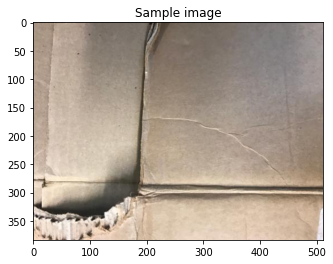

--------------------
Image shape: (384, 512, 3)
--------------------
Min image value: 0.0
Max image value: 255.0
--------------------
Train samples count: 1890
Test samples count: 500
--------------------
Test size: 20.92 % 



In [ ]:
sample_image = load_img(os.path.join(TRAIN_DATA_DIR,'cardboard/cardboard69.jpg'))
image_arr = img_to_array(sample_image)

plt.imshow(sample_image)
plt.title('Sample image')
plt.show()

subsection='-'*20
train_samples_count=sum([x for _,x in train_categories_count])
test_samples_count=sum([x for _,x in test_categories_count])

print(f'''{subsection}
Image shape: {image_arr.shape}
{subsection}
Min image value: {image_arr.min()}
Max image value: {image_arr.max()}
{subsection}
Train samples count: {train_samples_count}
Test samples count: {test_samples_count}
{subsection}
Test size: {round((test_samples_count / (train_samples_count + test_samples_count))*100, 2)} % 
''')

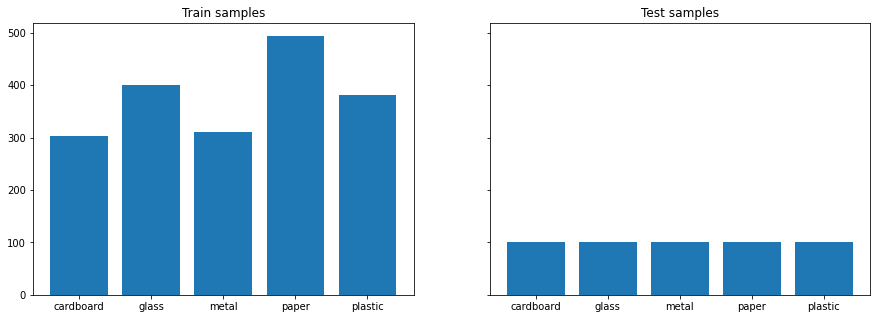

In [ ]:
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2, sharey=True)

ax[0].bar(x=[x for x,_ in train_categories_count],
          height=[x for _,x in train_categories_count])
ax[0].set_title('Train samples')

ax[1].bar(x=[x for x,_ in test_categories_count],
          height=[x for _,x in test_categories_count])
ax[1].set_title('Test samples')

plt.show()

# 3. Training

In [ ]:
TRAIN_DATA_DIR = 'garbage/train'
BATCH_SIZE = 16
EPOCHS_TRANSFER_LEARNING = 600
PATIENCE_TRANSFER_LEARNING = 50
EPOCHS_FINE_TUNING = 50
PATIENCE_FINE_TUNING = 10
VAL_SIZE = 0.2
N_CATEGORIES = len(categories)
IMAGE_SHAPE = image_arr.shape
TOP_HIDDEN_LAYERS = (100, 40, 20)
DROPOUT = 0.25

## ResNet50

In [ ]:
pipeline = TrainingPipe(image_shape=IMAGE_SHAPE,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS_TRANSFER_LEARNING)
pipeline.prepare_data_generator(data_dir=TRAIN_DATA_DIR,
                                preprocessing_function=ResNet_preprocess_function)

Found 1514 images belonging to 5 classes.
Found 376 images belonging to 5 classes.


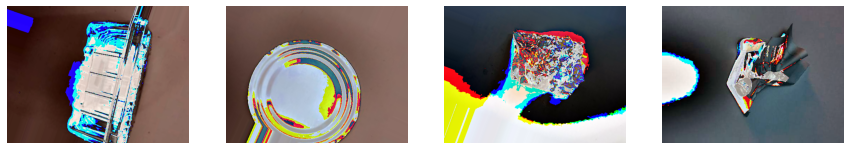

In [ ]:
pipeline.show_samples()

In [ ]:
resnet_model = ResNet50(weights="imagenet", 
                        include_top=False, 
                        input_shape=IMAGE_SHAPE)

In [ ]:
model = CustomModel(base_model=resnet_model,
                    top_hidden_layers=TOP_HIDDEN_LAYERS,
                    activation='sigmoid',
                    n_classes=N_CATEGORIES,
                    dropout=DROPOUT).get_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 12, 16, 2048)      23587712  
_________________________________________________________________
sequential_2 (Sequential)    (None, 5)                 39326665  
Total params: 62,914,377
Trainable params: 62,861,257
Non-trainable params: 53,120
_________________________________________________________________


Epoch 1/600
94/94 [==============================] - 99s 1s/step - loss: 1.5975 - accuracy: 0.2630 - val_loss: 1.5099 - val_accuracy: 0.4202
Epoch 2/600
94/94 [==============================] - 94s 997ms/step - loss: 1.5003 - accuracy: 0.3358 - val_loss: 1.4055 - val_accuracy: 0.4415
Epoch 3/600
94/94 [==============================] - 92s 983ms/step - loss: 1.3696 - accuracy: 0.4226 - val_loss: 1.2473 - val_accuracy: 0.4574
Epoch 4/600
94/94 [==============================] - 93s 989ms/step - loss: 1.2125 - accuracy: 0.4967 - val_loss: 1.1673 - val_accuracy: 0.5133
Epoch 5/600
94/94 [==============================] - 94s 1s/step - loss: 1.1212 - accuracy: 0.5267 - val_loss: 1.1024 - val_accuracy: 0.5266
Epoch 6/600
94/94 [==============================] - 93s 995ms/step - loss: 1.0671 - accuracy: 0.5507 - val_loss: 1.0608 - val_accuracy: 0.5346
Epoch 7/600
94/94 [==============================] - 94s 1s/step - loss: 1.0527 - accuracy: 0.5387 - val_loss: 1.0390 - val_accuracy: 0.5452
E

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: training/models/Resnet50/assets
Epoch 1/20
94/94 [==============================] - 110s 1s/step - loss: 1.0092 - accuracy: 0.5901 - val_loss: 1.0041 - val_accuracy: 0.5931
Epoch 2/20
94/94 [==============================] - 101s 1s/step - loss: 0.9689 - accuracy: 0.5888 - val_loss: 1.0159 - val_accuracy: 0.6064
Epoch 3/20
94/94 [==============================] - 100s 1s/step - loss: 0.9244 - accuracy: 0.6121 - val_loss: 1.0457 - val_accuracy: 0.6011
Epoch 4/20
94/94 [==============================] - 102s 1s/step - loss: 0.8918 - accuracy: 0.6335 - val_loss: 1.0748 - val_accuracy: 0.5904
Epoch 5/20
94/94 [==============================] - 102s 1s/step - loss: 0.8793 - accuracy: 0.6355 - val_loss: 1.0206 - val_accuracy: 0.6144
Epoch 6/20
94/94 [==============================] - 103s 1s/step - loss: 0.8602 - accuracy: 0.6529 - val_loss: 0.9583 - val_accuracy: 0.6356
Epoch 7/20
94/94 [==============================] - 101s 1s/step - loss: 0.8587 - accur

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: training/models/Resnet50_fine_tuning/assets





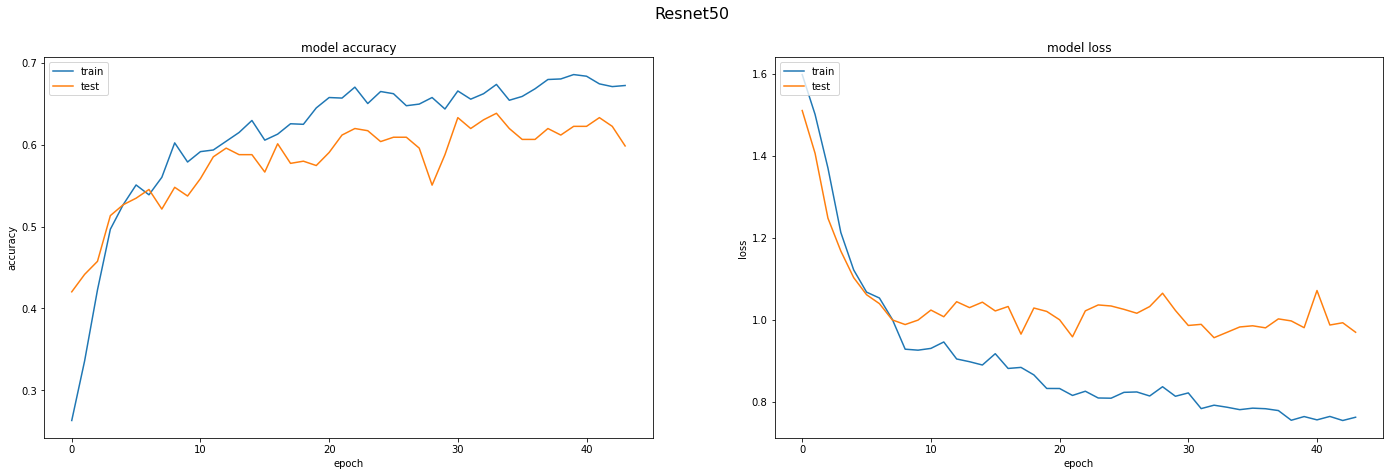

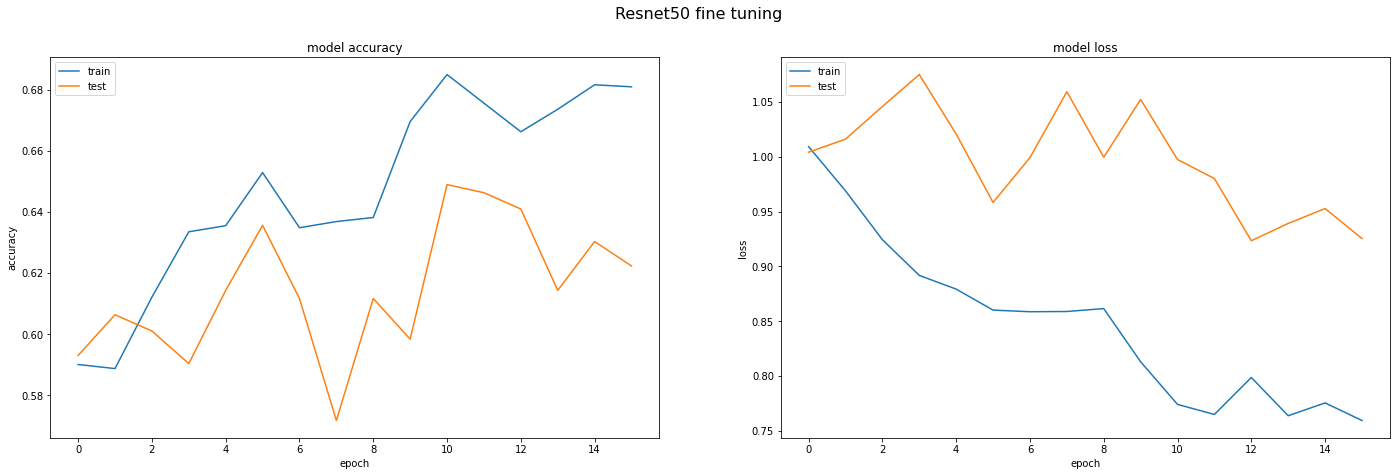

In [ ]:
pipeline.train_model(model_name='ResNet50', 
                     model=model,
                     with_fine_tuning=True)

## EfficienNetB3

In [ ]:
pipeline = TrainingPipe(image_shape=IMAGE_SHAPE,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS_TRANSFER_LEARNING)
pipeline.prepare_data_generator(data_dir=TRAIN_DATA_DIR, 
                                preprocessing_function=EfficientNet_preprocess_function)

Found 1514 images belonging to 5 classes.
Found 376 images belonging to 5 classes.


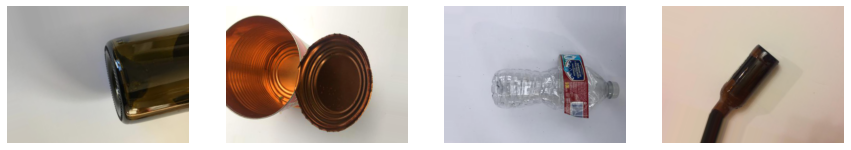

In [ ]:
pipeline.show_samples()

In [ ]:
efficientnet_model = EfficientNetB3(weights="imagenet", 
                                    include_top=False, 
                                    input_shape=IMAGE_SHAPE)

In [ ]:
model = CustomModel(base_model=efficientnet_model,
                    top_hidden_layers=TOP_HIDDEN_LAYERS,
                    activation='sigmoid',
                    n_classes=N_CATEGORIES,
                    dropout=DROPOUT).get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 12, 16, 1536)      10783535  
_________________________________________________________________
sequential (Sequential)      (None, 5)                 29496265  
Total params: 40,279,800
Trainable params: 40,192,497
Non-trainable params: 87,303
_________________________________________________________________


Epoch 1/600
94/94 [==============================] - 104s 1s/step - loss: 1.5025 - accuracy: 0.3511 - val_loss: 1.3801 - val_accuracy: 0.4947
Epoch 2/600
94/94 [==============================] - 92s 985ms/step - loss: 1.2772 - accuracy: 0.4887 - val_loss: 1.2083 - val_accuracy: 0.5080
Epoch 3/600
94/94 [==============================] - 91s 971ms/step - loss: 1.1140 - accuracy: 0.5741 - val_loss: 1.1181 - val_accuracy: 0.5239
Epoch 4/600
94/94 [==============================] - 91s 974ms/step - loss: 1.0004 - accuracy: 0.5921 - val_loss: 1.0620 - val_accuracy: 0.5426
Epoch 5/600
94/94 [==============================] - 93s 987ms/step - loss: 0.9483 - accuracy: 0.6081 - val_loss: 1.0382 - val_accuracy: 0.5691
Epoch 6/600
94/94 [==============================] - 93s 989ms/step - loss: 0.9040 - accuracy: 0.6121 - val_loss: 1.0128 - val_accuracy: 0.5638
Epoch 7/600
94/94 [==============================] - 92s 981ms/step - loss: 0.8598 - accuracy: 0.6522 - val_loss: 1.0044 - val_accuracy: 0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: training/models/EfficientNetB3/assets
Epoch 1/20
94/94 [==============================] - 134s 1s/step - loss: 1.4407 - accuracy: 0.4960 - val_loss: 0.9170 - val_accuracy: 0.6649
Epoch 2/20
94/94 [==============================] - 117s 1s/step - loss: 1.3866 - accuracy: 0.5214 - val_loss: 1.0559 - val_accuracy: 0.6011
Epoch 3/20
94/94 [==============================] - 118s 1s/step - loss: 1.3092 - accuracy: 0.5260 - val_loss: 1.1638 - val_accuracy: 0.5745
Epoch 4/20
94/94 [==============================] - 117s 1s/step - loss: 1.1825 - accuracy: 0.5527 - val_loss: 1.1957 - val_accuracy: 0.5372
Epoch 5/20
94/94 [==============================] - 116s 1s/step - loss: 1.1816 - accuracy: 0.5774 - val_loss: 1.1898 - val_accuracy: 0.5718
Epoch 6/20
94/94 [==============================] - 119s 1s/step - loss: 1.1007 - accuracy: 0.5961 - val_loss: 1.2350 - val_accuracy: 0.5931


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: training/models/EfficientNetB3_fine_tuning/assets





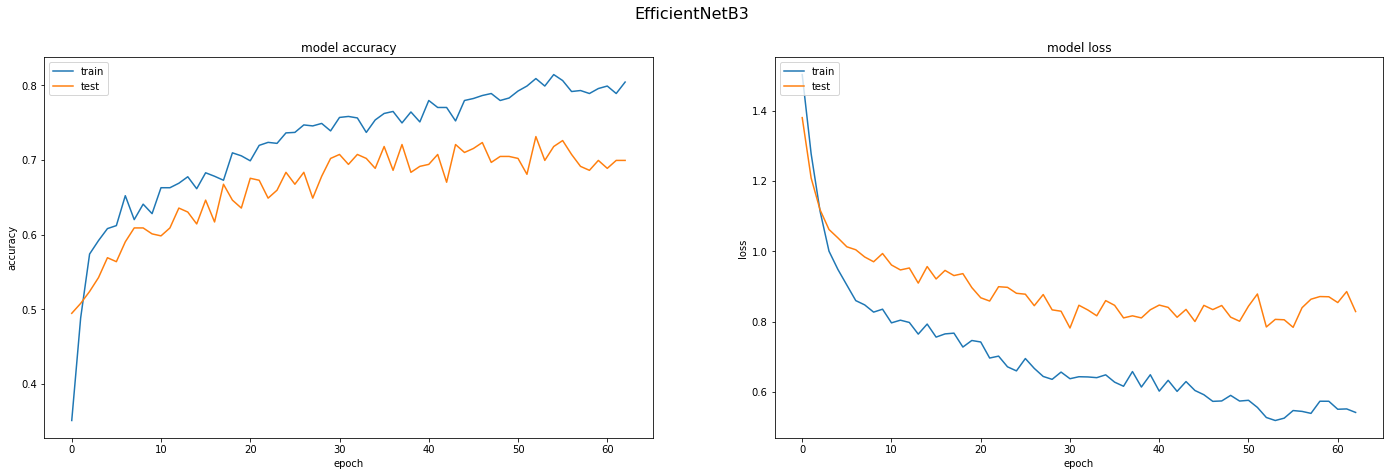

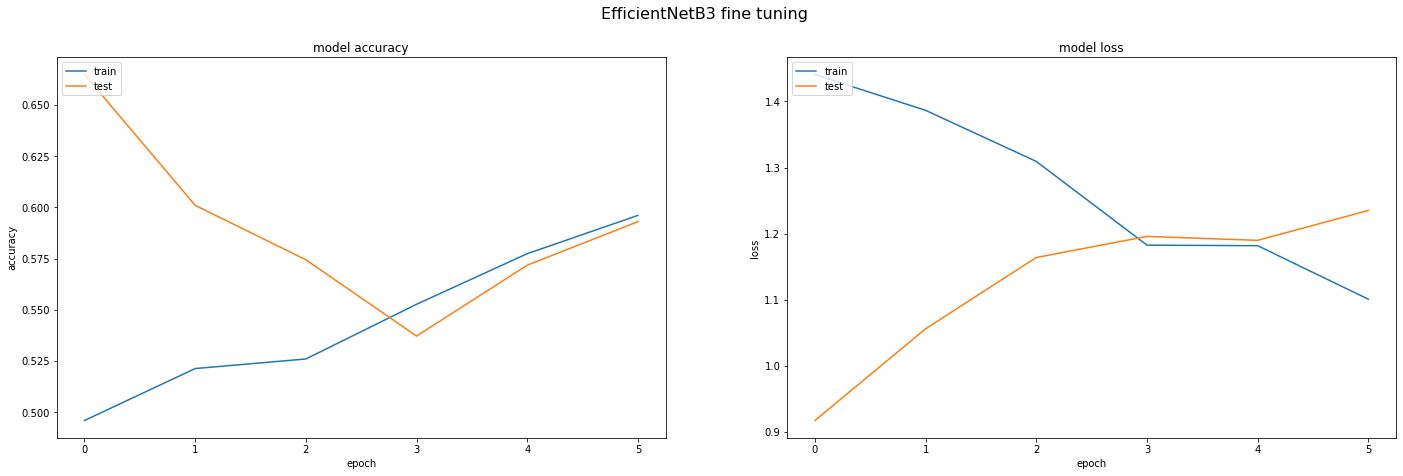

In [ ]:
pipeline.train_model(model_name='EfficientNetB3', 
                     model=model, 
                     with_fine_tuning=True)

# 4. Evaluation

In [3]:
TEST_DATA_DIR = 'garbage/test'

resnet_model = load_model('training/models/Resnet50')
resnet_ft_model = load_model('training/models/Resnet50_fine_tuning')
efficientnet_model = load_model('training/models/EfficientNetB3')
efficientnet_ft_model = load_model('training/models/EfficientNetB3_fine_tuning')

## ResNet50

In [4]:
resnet_evaluator = ModelEvaluator(model=resnet_model)
resnet_evaluator.prepare_data_generator(data_dir=TEST_DATA_DIR)

resnet_evaluator.accuracy_score()

Found 500 images belonging to 5 classes.
Model accuracy score: 0.588


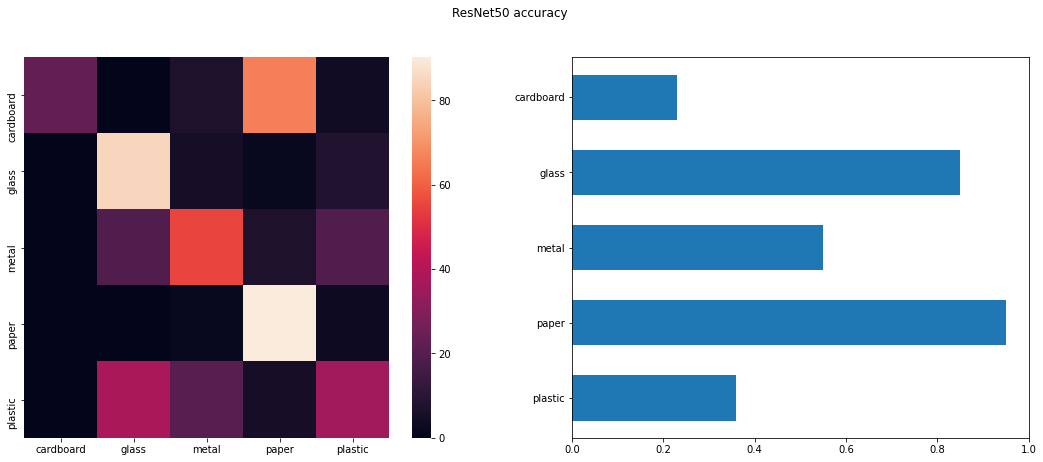

In [11]:
resnet_evaluator.confusion_matrix_categorical_accuracy(title='ResNet50 accuracy')

In [57]:
resnet_ft_evaluator = ModelEvaluator(model=resnet_ft_model)
resnet_ft_evaluator.prepare_data_generator(data_dir=TEST_DATA_DIR)

resnet_ft_evaluator.accuracy_score()

Found 500 images belonging to 5 classes.
Model accuracy score: 0.55


## EfficienNetB3

In [ ]:
efficientnet_evaluator = ModelEvaluator(model=efficientnet_model)
efficientnet_evaluator.prepare_data_generator(data_dir=TEST_DATA_DIR)

efficientnet_evaluator.accuracy_score()

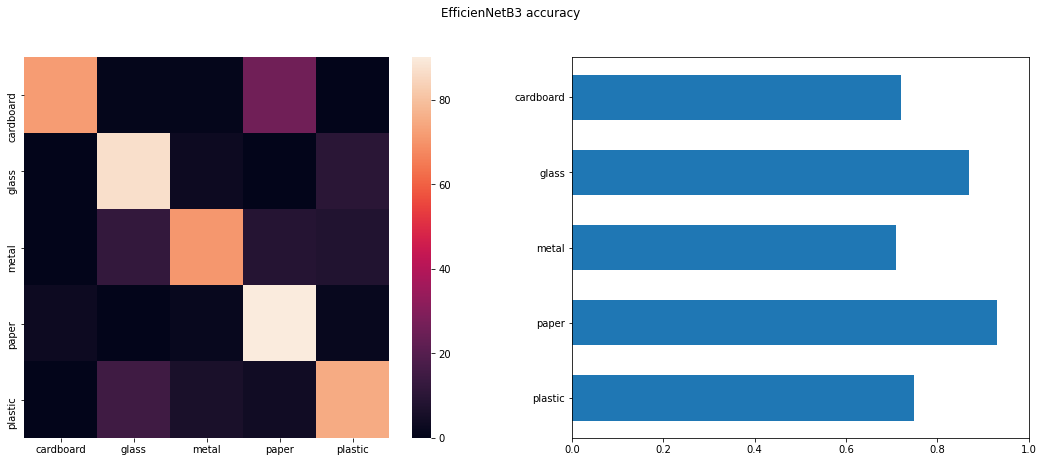

In [13]:
efficientnet_evaluator.confusion_matrix_categorical_accuracy(title='EfficienNetB3 accuracy')

In [ ]:
efficientnet_ft_evaluator = ModelEvaluator(model=efficientnet_ft_model)
efficientnet_ft_evaluator.prepare_data_generator(data_dir=TEST_DATA_DIR)

efficientnet_ft_evaluator.accuracy_score()

## Model comparison

In [52]:
df_good, df_misclasified = ModelEvaluator.categorical_classification([('ResNet50',resnet_evaluator),
                                                                      ('ResNet50_fine _tuning', resnet_ft_evaluator),
                                                                      ('EfficientNetB3',efficientnet_evaluator),
                                                                      ('EfficientNetB3_fine_tuning',efficientnet_ft_evaluator)])

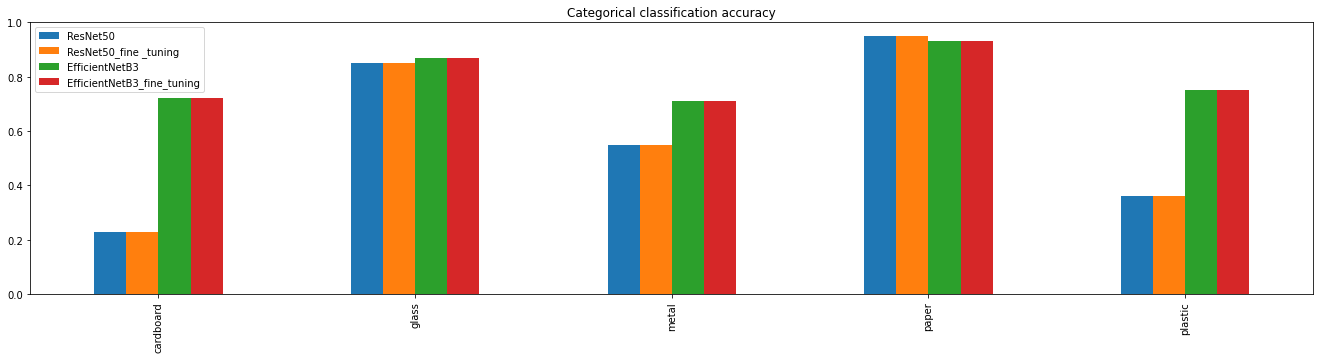

In [64]:
_ = df_good.plot.bar(figsize=(23,5), title='Categorical classification accuracy', ylim=[0,1])

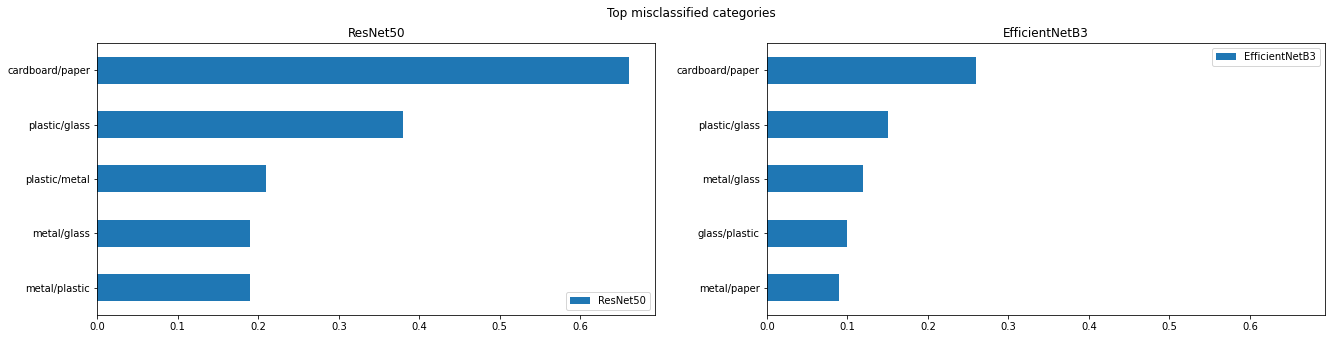

In [62]:
fig, ax = plt.subplots(figsize=(22,5), nrows=1, ncols=2, sharex=True)
plt.suptitle('Top misclassified categories')
df_misclasified[['ResNet50']].sort_values(by=['ResNet50'], ascending=False).head()[::-1].plot.barh(ax=ax[0])
ax[0].set_title('ResNet50')
df_misclasified[['EfficientNetB3']].sort_values(by=['EfficientNetB3'], ascending=False).head()[::-1].plot.barh(ax=ax[1])
ax[1].set_title('EfficientNetB3')
plt.show()

# 5. Prediction on new images

# 6. Summary